## Compare temporal Trophic Level using Stock et al. 2014 with ingestion-derived TL

In [1]:
%matplotlib inline
import warnings
warnings.simplefilter("ignore") # Silence warnings
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
import math
from matplotlib.pyplot import figure

# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab

# Scientific libraries
from numpy import arange,array,ones
from scipy import stats
import seaborn as sns
import scipy.io as sio
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import pylab 
from copy import deepcopy
import pandas as pd
import os
import matplotlib.gridspec as gridspec
import matplotlib
import cartopy
import matplotlib.colors as colors
import cmocean

In [2]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [3]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [4]:
### 20 year climatology GNG513b from 43 to 62 representing Jan 1990 - Dec 2009.
path = '/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/GNG595_2ndcycle_1990-2009_clim'
files = sorted(glob.glob(f'{path}/*.nc', recursive=True),key=numericalSort)
ds= xr.open_mfdataset(files,combine='by_coords')

In [5]:
TL_m1= xr.open_mfdataset('/glade/u/home/gabyn/Notebook_scripts/Chapter2/mesozoo_TL_method1_regrid.nc')
TL_m2= xr.open_mfdataset('/glade/u/home/gabyn/Notebook_scripts/Chapter2/mesozoo_TL_method2_regrid.nc')

	NC4_open: path /glade/u/home/gabyn/Notebook_scripts/Chapter2/mesozoo_TL_method1_regrid.nc mode 4096 params 0
	HDF5 error messages turned on.
			nc4_open_file: path /glade/u/home/gabyn/Notebook_scripts/Chapter2/mesozoo_TL_method1_regrid.nc mode 4096
			nc4_grp_list_add: name / 
			nc4_rec_read_metadata: grp->hdr.name /
			found dataset time
			found dataset lon
			found dataset lat
			found dataset z_t_150m
			found dataset mesozoo_TL_m1
ERROR: Invalid _NCProperties attribute
		*** NetCDF-4 Internal Metadata: int_ncid 0xd0000 ext_ncid 0xd0000
		FILE - path: /glade/u/home/gabyn/Notebook_scripts/Chapter2/mesozoo_TL_method1_regrid.nc cmode: 0x1008 parallel: 0 redef: 0 fill_mode: 0 no_write: 1 next_nc_grpid: 1
		 GROUP - / nc_grpid: 0 nvars: 5 natts: 0
		 DIMENSION - dimid: 0 name: time len: 12 unlimited: 1
		 DIMENSION - dimid: 1 name: lon len: 360 unlimited: 0
		 DIMENSION - dimid: 2 name: lat len: 180 unlimited: 0
		 DIMENSION - dimid: 3 name: z_t_150m len: 15 unlimited: 0
		 VARIABLE -

		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_dim: ncid 0xd0000 dimid 0
		NC4_inq_dim: ncid 0xd0000 dimid 3
		NC4_inq_dim: ncid 0xd0000 dimid 2
		NC4_inq_dim: ncid 0xd0000 dimid 1
		NC4_inq_dim: ncid 0xd0000 dimid 0
			nc4_find_dim_len: grp->name / dimid 0
		NC4_inq_dim: ncid 0xd0000 dimid 3
		NC4_inq_dim: ncid 0xd0000 dimid 2
		NC4_inq_dim: ncid 0xd0000 dimid 1
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_dim: ncid 0xd0000 dimid 0
		NC4_inq_dim: ncid 0xd0000 dimid 3
		NC4_inq_dim: ncid 0xd0000 dimid 2
		NC4_inq_dim: ncid 0xd0000 dimid 1
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_dim: ncid 0xd0000 dimid 0
		NC4_inq_dim: ncid 0xd0000 dimid 3
		NC4_inq_dim: ncid 0xd0000 dimid 2
		NC4_inq_dim: ncid 0xd0000 dimid 1
		NC4_inq_var_all: ncid 0xd0000 varid 4
			NC4_get_vars: var->hdr.name mesozoo_TL_m1 mem_nc_type 6
		NC4_inq_dim: ncid 0xd0000 dimid 0
			nc4_f

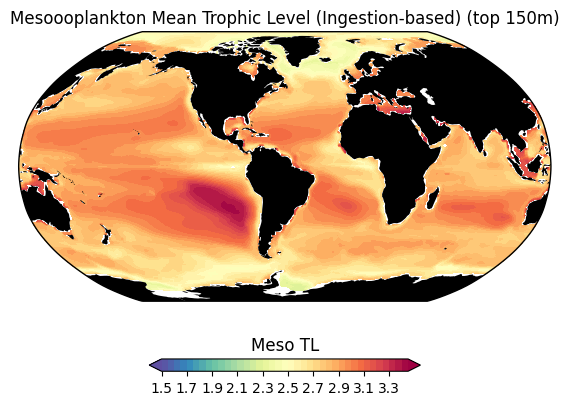

In [28]:
from cartopy.util import add_cyclic_point
from mpl_toolkits.basemap import Basemap
lev = np.arange(1.5, 3.5, 0.05)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=2.5)

fig = plt.figure(figsize=(7, 5))
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
zoo, lon = add_cyclic_point(np.nanmean(TL_m1.mesozoo_TL_m1,axis=(0,1)), coord=TL_m1.lon, axis=1)
x, y = m(*np.meshgrid(lon,TL_m1.lat))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(x, y, zoo, cmap='Spectral_r', levels=lev, norm = norm,extend='both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('Meso TL')
ax.set_title('Mesoooplankton Mean Trophic Level (Ingestion-based) (top 150m)');

		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_dim: ncid 0xd0000 dimid 0
		NC4_inq_dim: ncid 0xd0000 dimid 3
		NC4_inq_dim: ncid 0xd0000 dimid 2
		NC4_inq_dim: ncid 0xd0000 dimid 1
		NC4_inq_dim: ncid 0xd0000 dimid 0
			nc4_find_dim_len: grp->name / dimid 0
		NC4_inq_dim: ncid 0xd0000 dimid 3
		NC4_inq_dim: ncid 0xd0000 dimid 2
		NC4_inq_dim: ncid 0xd0000 dimid 1
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_dim: ncid 0xd0000 dimid 0
		NC4_inq_dim: ncid 0xd0000 dimid 3
		NC4_inq_dim: ncid 0xd0000 dimid 2
		NC4_inq_dim: ncid 0xd0000 dimid 1
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_dim: ncid 0xd0000 dimid 0
		NC4_inq_dim: ncid 0xd0000 dimid 3
		NC4_inq_dim: ncid 0xd0000 dimid 2
		NC4_inq_dim: ncid 0xd0000 dimid 1
		NC4_inq_var_all: ncid 0xd0000 varid 4
			NC4_get_vars: var->hdr.name mesozoo_TL_m1 mem_nc_type 6
		NC4_inq_dim: ncid 0xd0000 dimid 0
			nc4_f

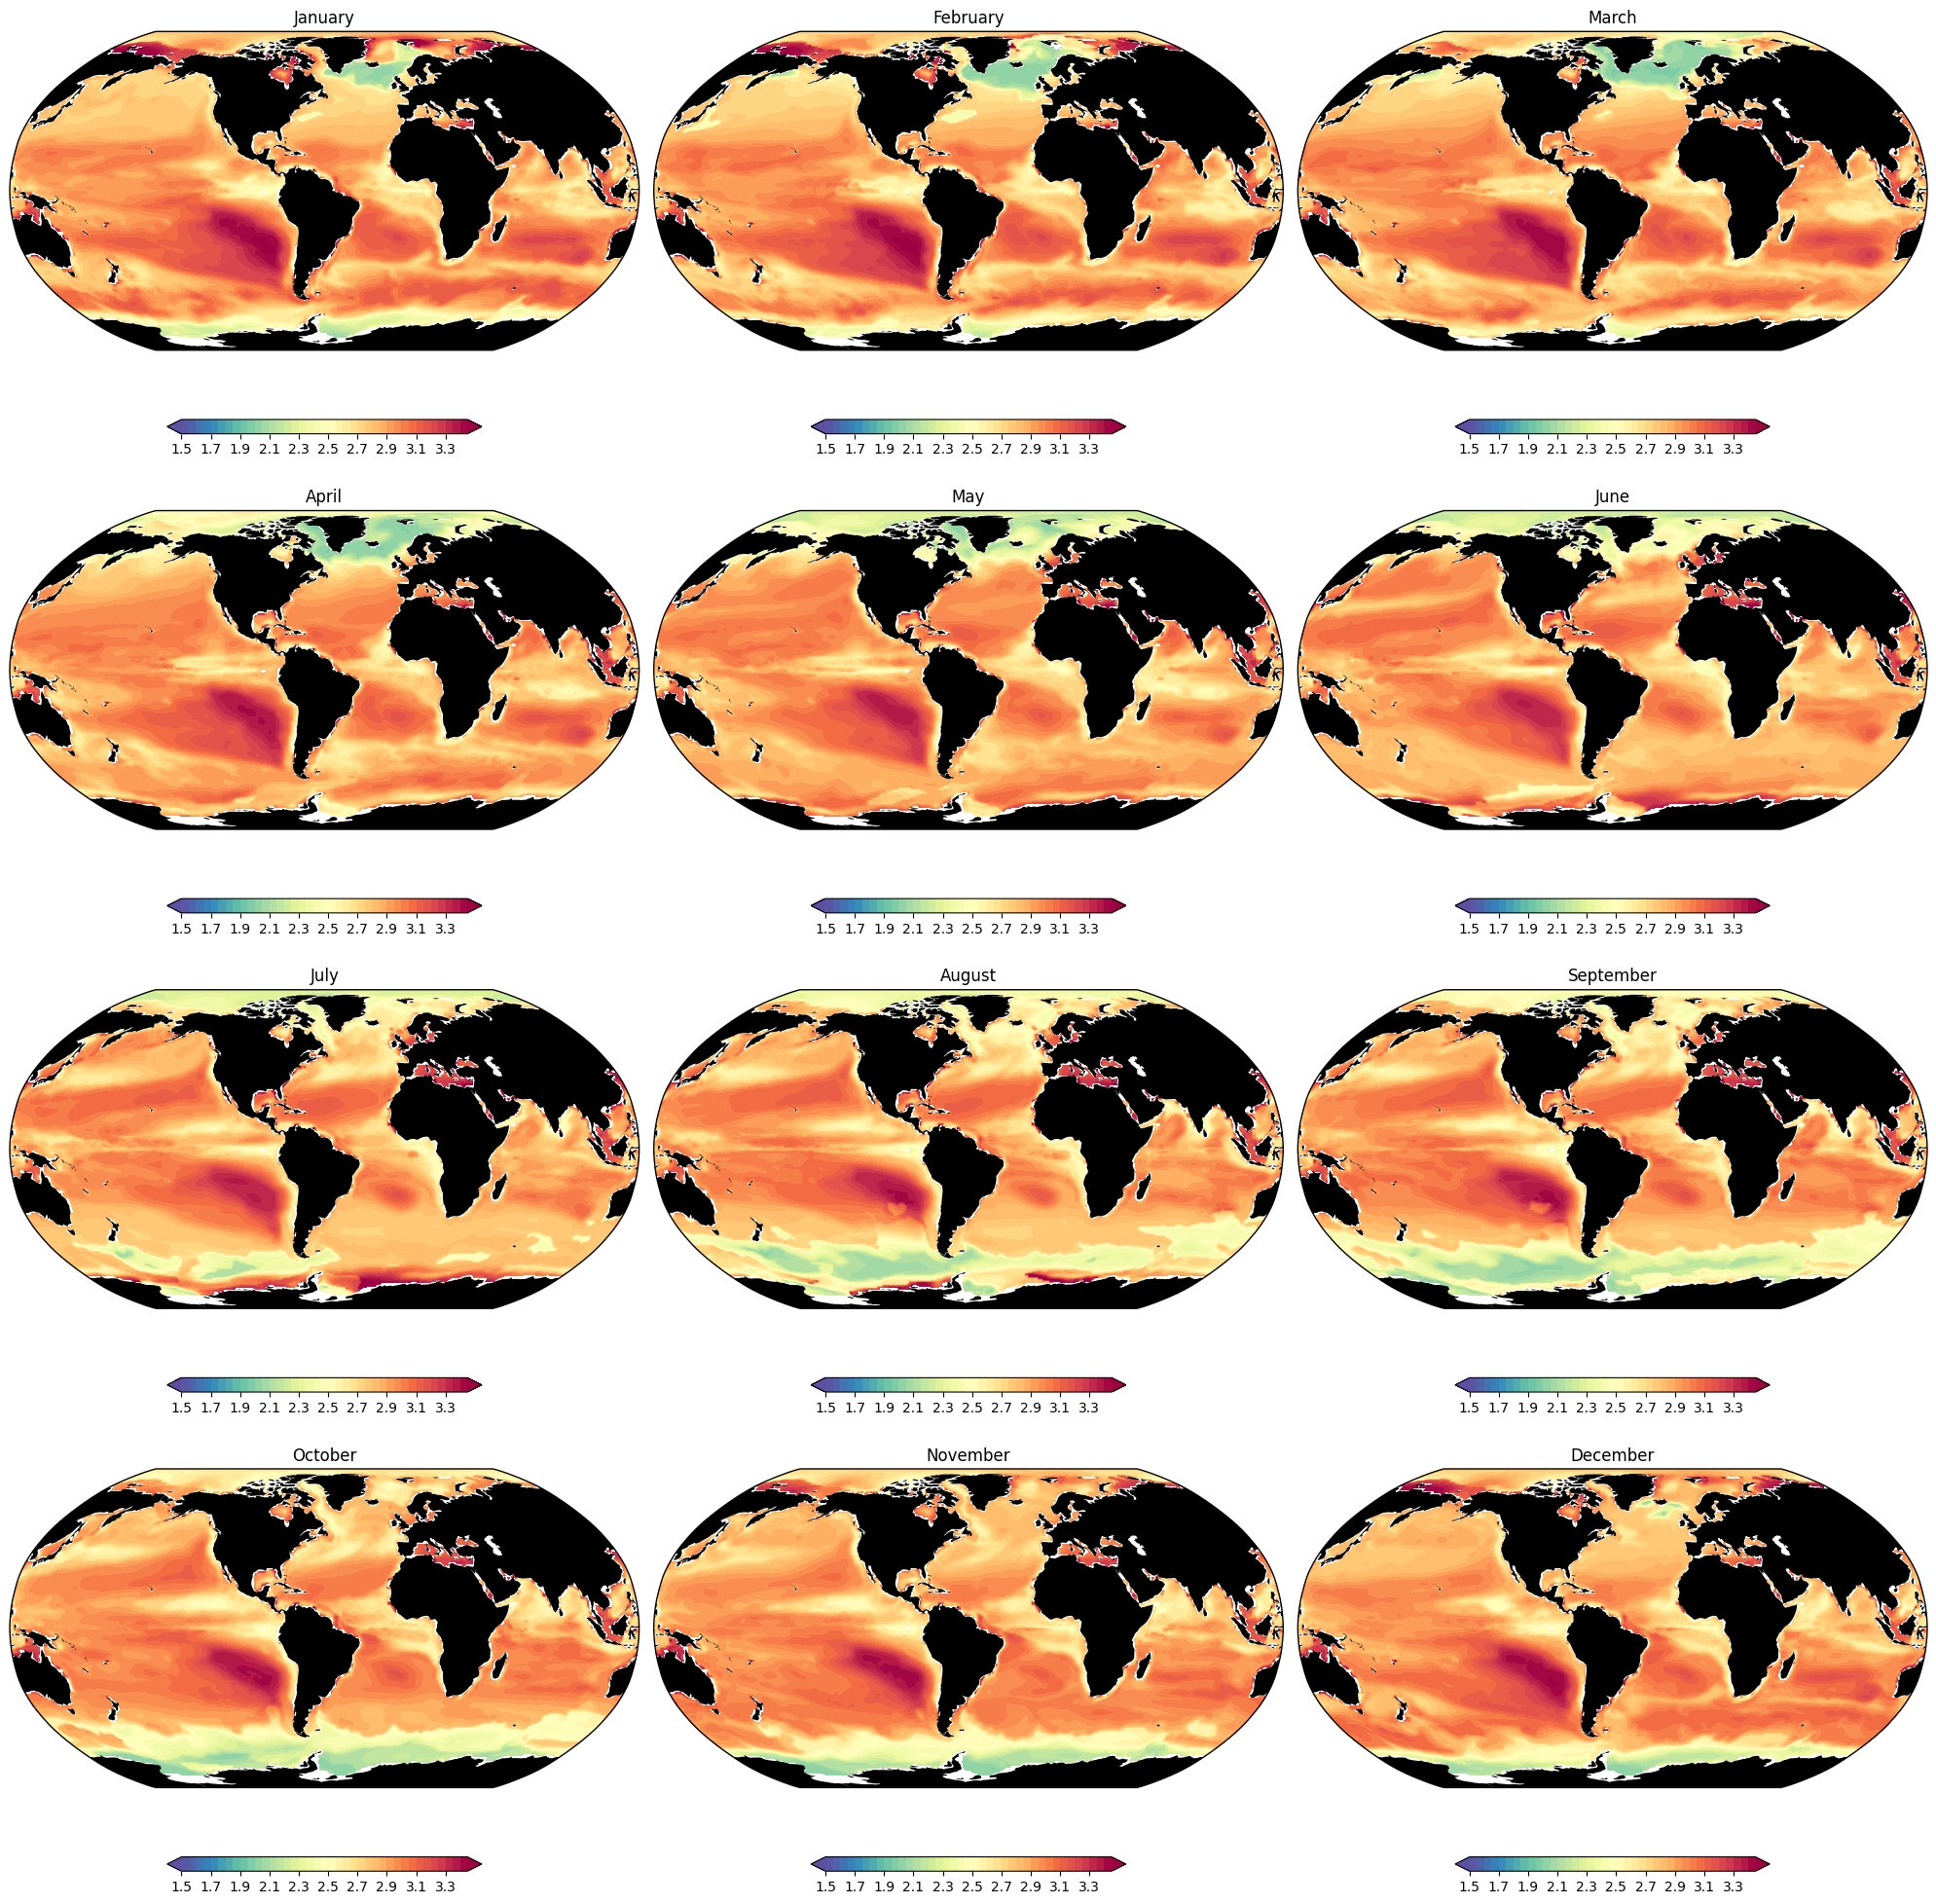

In [34]:
lev = np.arange(1.5, 3.5, 0.05)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=2.5)
month = ['January','February','March','April','May','June','July','August','September','October','November','December']
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
fig = plt.figure(figsize=(20, 20))
for i in range(0,12):
    zoo, lon = add_cyclic_point(np.nanmean(TL_m1.mesozoo_TL_m1[i,:,:,:],axis=(0)), coord=TL_m1.lon, axis=1)
    x, y = m(*np.meshgrid(lon,TL_m1.lat))
    ax = fig.add_subplot(4, 3, 1+i, projection=ccrs.Robinson(central_longitude=305.0))
    cf = ax.contourf(x, y, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
    land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
    cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
    ax.set_title(month[i]+'');
plt.tight_layout()

		NC4_inq_var_all: ncid 0xe0000 varid 3
		NC4_inq_var_all: ncid 0xe0000 varid 3
		NC4_inq_dim: ncid 0xe0000 dimid 0
		NC4_inq_dim: ncid 0xe0000 dimid 2
		NC4_inq_dim: ncid 0xe0000 dimid 1
		NC4_inq_dim: ncid 0xe0000 dimid 0
			nc4_find_dim_len: grp->name / dimid 0
		NC4_inq_dim: ncid 0xe0000 dimid 2
		NC4_inq_dim: ncid 0xe0000 dimid 1
		NC4_inq_var_all: ncid 0xe0000 varid 3
		NC4_inq_var_all: ncid 0xe0000 varid 3
		NC4_inq_dim: ncid 0xe0000 dimid 0
		NC4_inq_dim: ncid 0xe0000 dimid 2
		NC4_inq_dim: ncid 0xe0000 dimid 1
		NC4_inq_var_all: ncid 0xe0000 varid 3
		NC4_inq_var_all: ncid 0xe0000 varid 3
		NC4_inq_dim: ncid 0xe0000 dimid 0
		NC4_inq_dim: ncid 0xe0000 dimid 2
		NC4_inq_dim: ncid 0xe0000 dimid 1
		NC4_inq_var_all: ncid 0xe0000 varid 3
			NC4_get_vars: var->hdr.name zoo_TL_m2 mem_nc_type 6
		NC4_inq_dim: ncid 0xe0000 dimid 0
			nc4_find_dim_len: grp->name / dimid 0
		NC4_inq_var_all: ncid 0xe0000 varid 3
		NC4_inq_var_all: ncid 0xe0000 varid 3
		NC4_inq_dim: ncid 0xe0000 dimid 0

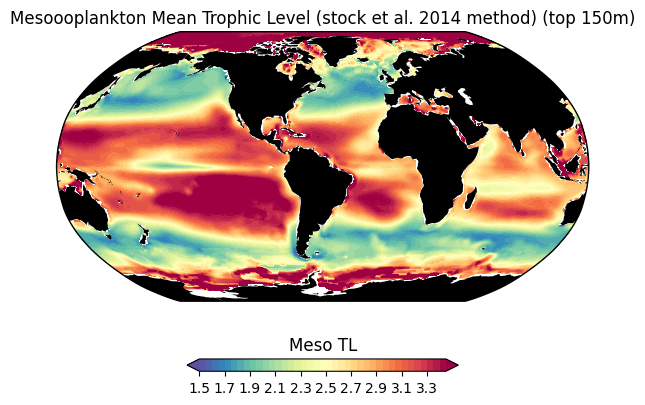

In [32]:
lev = np.arange(1.5, 3.5, 0.05)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=2.5)

fig = plt.figure(figsize=(7, 5))
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
zoo, lon = add_cyclic_point(np.nanmean(TL_m2.zoo_TL_m2,axis=(0)), coord=TL_m1.lon, axis=1)
x, y = m(*np.meshgrid(lon,TL_m1.lat))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(x, y, zoo, cmap='Spectral_r', levels=lev, norm = norm,extend='both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('Meso TL')
ax.set_title('Mesoooplankton Mean Trophic Level (stock et al. 2014 method) (top 150m)');

		NC4_inq_var_all: ncid 0xe0000 varid 3
		NC4_inq_var_all: ncid 0xe0000 varid 3
		NC4_inq_dim: ncid 0xe0000 dimid 0
		NC4_inq_dim: ncid 0xe0000 dimid 2
		NC4_inq_dim: ncid 0xe0000 dimid 1
		NC4_inq_dim: ncid 0xe0000 dimid 0
			nc4_find_dim_len: grp->name / dimid 0
		NC4_inq_dim: ncid 0xe0000 dimid 2
		NC4_inq_dim: ncid 0xe0000 dimid 1
		NC4_inq_var_all: ncid 0xe0000 varid 3
		NC4_inq_var_all: ncid 0xe0000 varid 3
		NC4_inq_dim: ncid 0xe0000 dimid 0
		NC4_inq_dim: ncid 0xe0000 dimid 2
		NC4_inq_dim: ncid 0xe0000 dimid 1
		NC4_inq_var_all: ncid 0xe0000 varid 3
		NC4_inq_var_all: ncid 0xe0000 varid 3
		NC4_inq_dim: ncid 0xe0000 dimid 0
		NC4_inq_dim: ncid 0xe0000 dimid 2
		NC4_inq_dim: ncid 0xe0000 dimid 1
		NC4_inq_var_all: ncid 0xe0000 varid 3
			NC4_get_vars: var->hdr.name zoo_TL_m2 mem_nc_type 6
		NC4_inq_dim: ncid 0xe0000 dimid 0
			nc4_find_dim_len: grp->name / dimid 0
		NC4_inq_var_all: ncid 0xe0000 varid 3
		NC4_inq_var_all: ncid 0xe0000 varid 3
		NC4_inq_dim: ncid 0xe0000 dimid 0

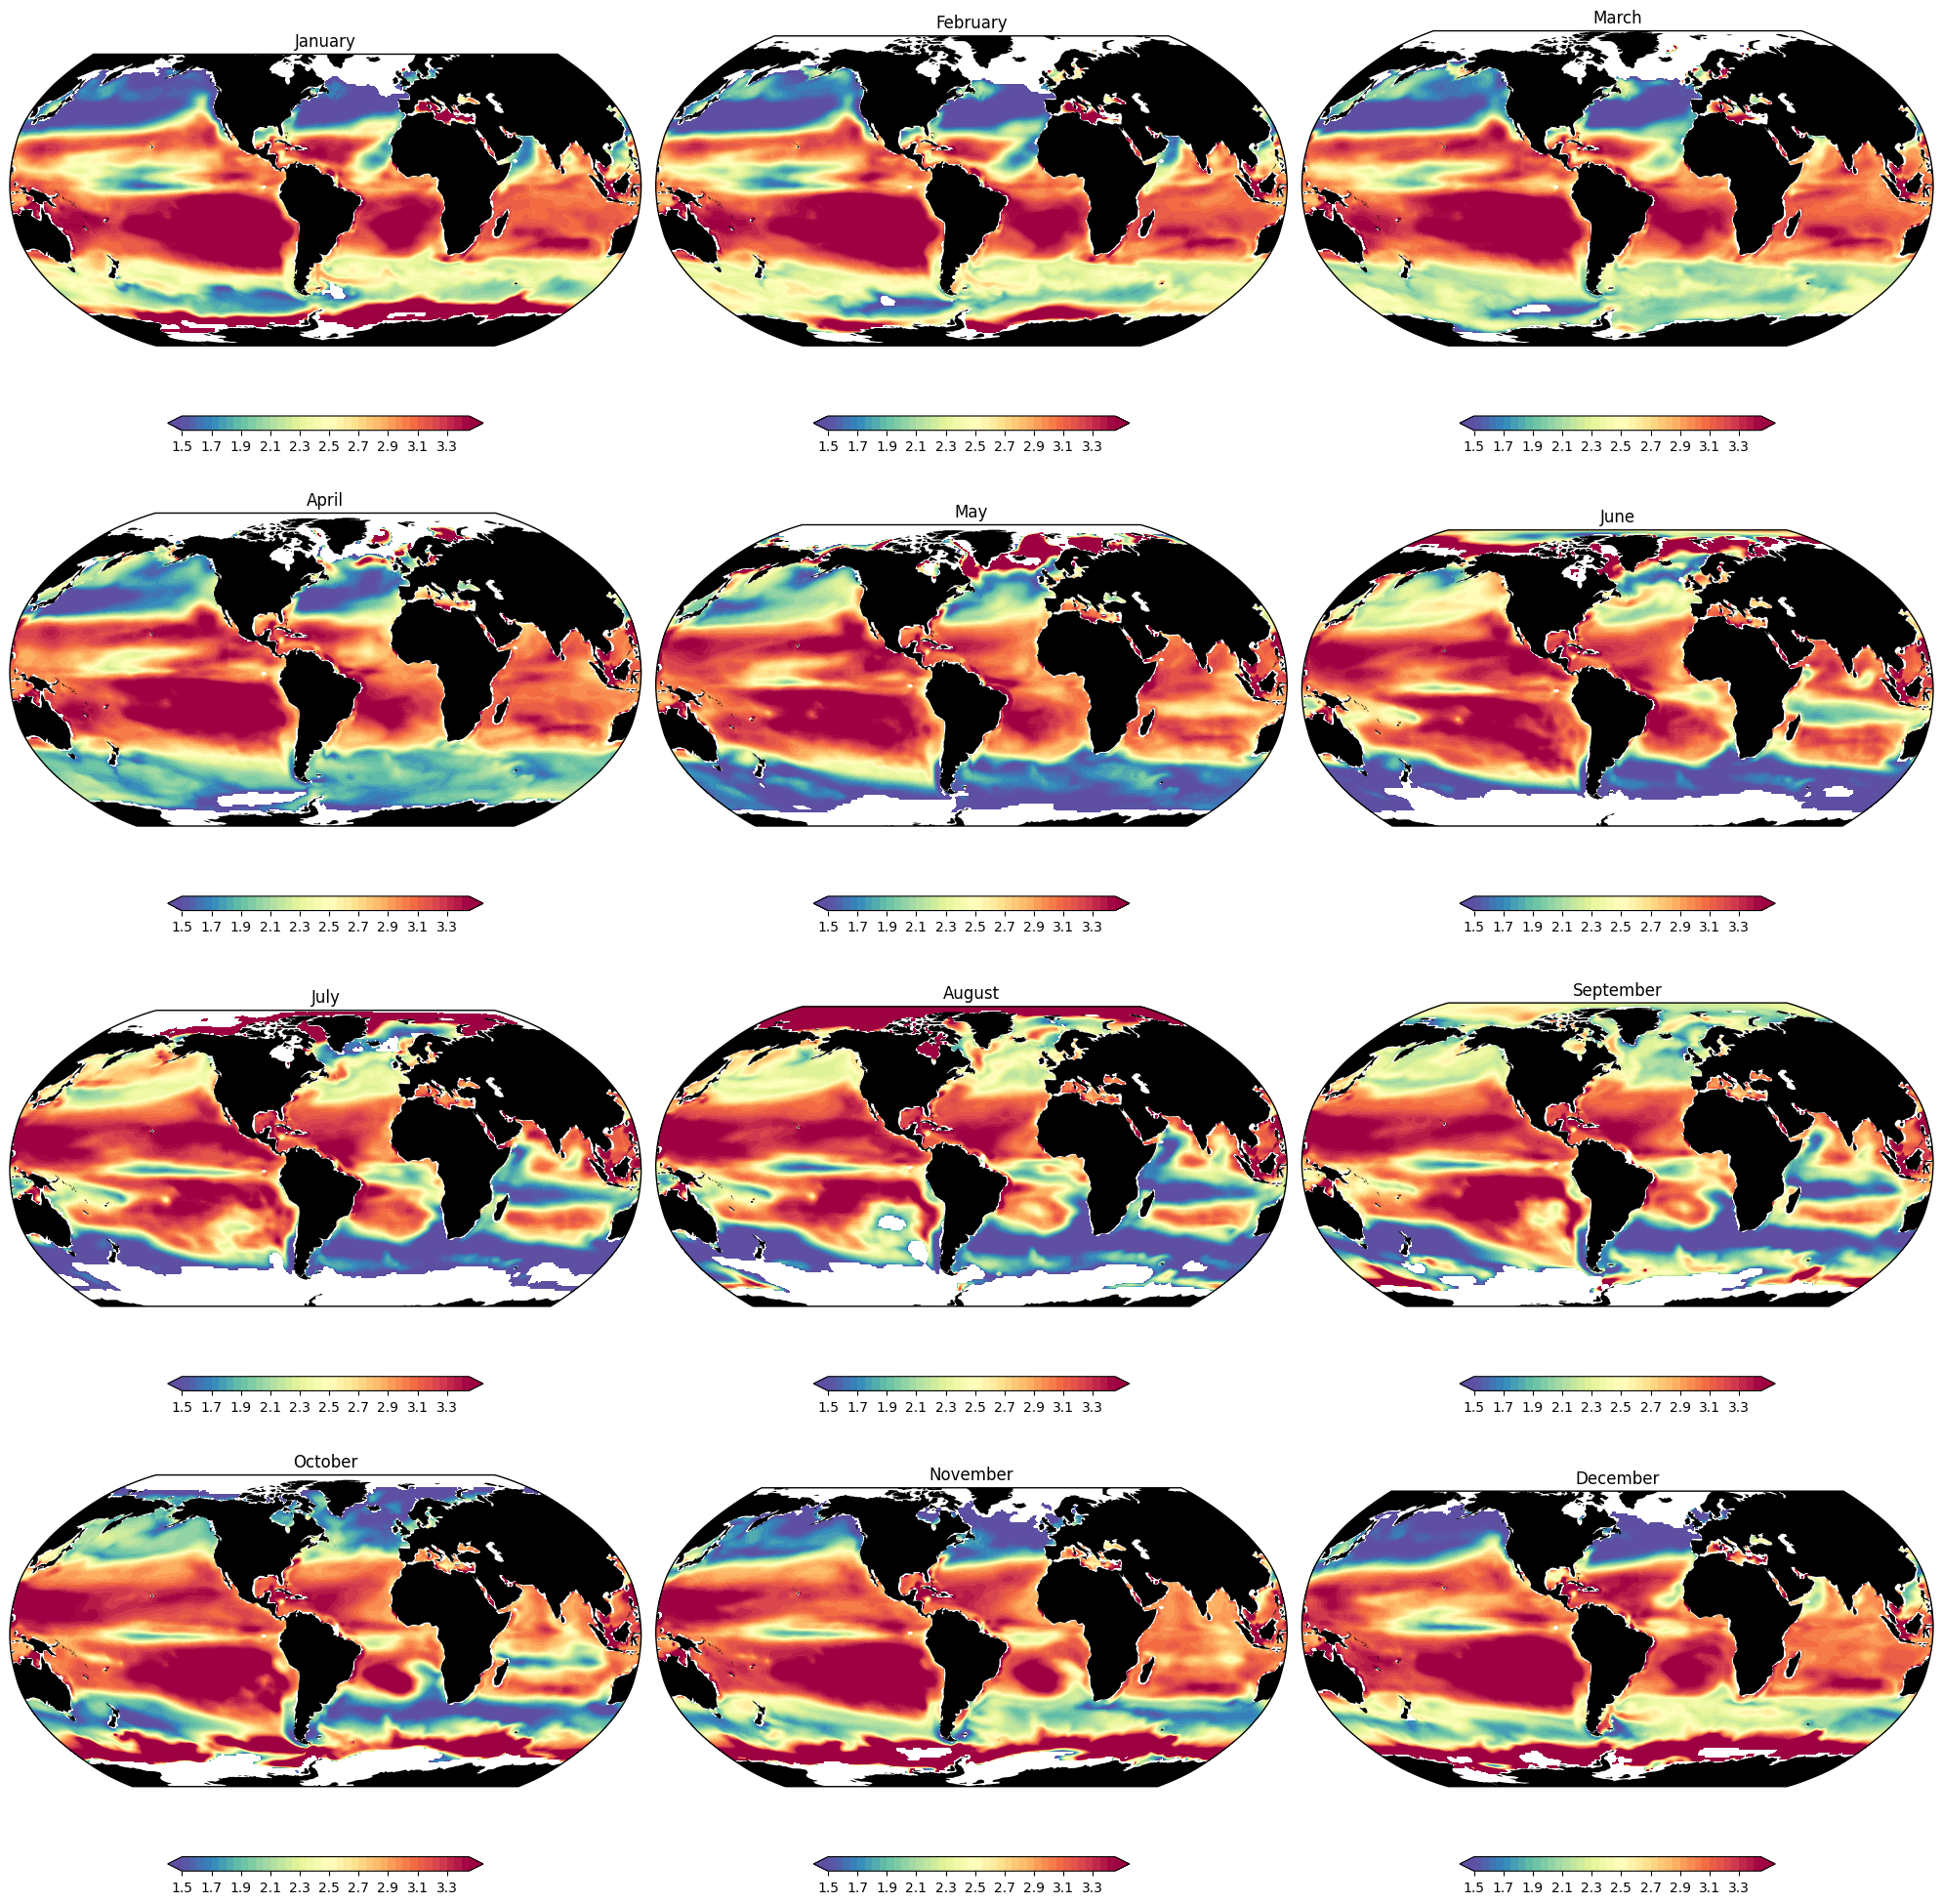

In [35]:
lev = np.arange(1.5, 3.5, 0.05)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=2.5)
month = ['January','February','March','April','May','June','July','August','September','October','November','December']
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
fig = plt.figure(figsize=(20, 20))
for i in range(0,12):
    zoo, lon = add_cyclic_point(TL_m2.zoo_TL_m2[i,:,:], coord=TL_m1.lon, axis=1)
    x, y = m(*np.meshgrid(lon,TL_m1.lat))
    ax = fig.add_subplot(4, 3, 1+i, projection=ccrs.Robinson(central_longitude=305.0))
    cf = ax.contourf(x, y, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
    land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
    cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
    ax.set_title(month[i]+'');
plt.tight_layout()

## Now let's do temporal profiles 

In [6]:
# (31°40′ N, 64°10′ W)
# longitude in degrees East
EQ_lon = np.where(TL_m2.lon == -99)
NA_lon = np.where(TL_m2.lon == -30)
SO_lon = np.where(TL_m2.lon == -173)
res_lon4 = np.where(TL_m2.lon == -40)
BATS_lon = np.where(TL_m2.lon == -64)
SPNP_lon = np.where(TL_m2.lon == -145)
AO_lon = np.where(TL_m2.lon == -2)
SOICE_lon = np.where(TL_m2.lon == -95)
SP_lon = np.where(TL_m2.lon==-165)

# Latitude degrees_north
EQ_lat = np.where(TL_m2.lat == 1.5)
NA_lat= np.where(TL_m2.lat == 48.5)
SO_lat= np.where(TL_m2.lat == -58.5)
res_lat4 = np.where(TL_m2.lat == -68.5)
BATS_lat = np.where(TL_m2.lat == 31.5)
SPNP_lat = np.where(TL_m2.lat == 50.5)
AO_lat = np.where(TL_m2.lat == 81.5)
SOICE_lat = np.where(TL_m2.lat == -21.5)
SP_lat = np.where(TL_m2.lat== 24.5)

In [7]:
NA_TL_m2       = np.mean(TL_m2.zoo_TL_m2[:,136:141,148:153],axis=(1,2))
BATS_TL_m2     = np.mean(TL_m2.zoo_TL_m2[:,119:124,114:119],axis=(1,2))
PAPA_TL_m2     = np.mean(TL_m2.zoo_TL_m2[:,137:141,32:37],axis=(1,2))
EQ_OMZ_TL_m2   = np.mean(TL_m2.zoo_TL_m2[:,89:94,79:84],axis=(1,2))
SO_ICE_TL_m2   = np.mean(TL_m2.zoo_TL_m2[:,19:24,138:143],axis=(1,2))
SO_TL_m2       = np.mean(TL_m2.zoo_TL_m2[:,28:33,5:10],axis=(1,2))
AO_TL_m2       = np.mean(TL_m2.zoo_TL_m2[:,168:173,175:180],axis=(1,2))
OP_TL_m2       = np.mean(TL_m2.zoo_TL_m2[:,66:71,5:10],axis=(1,2))
SP_TL_m2       = np.mean(TL_m2.zoo_TL_m2[:,111:116,12:17],axis=(1,2))

NA_TL_m1       = np.mean(TL_m1.mesozoo_TL_m1[:,:,136:141,148:153],axis=(1,2,3))
BATS_TL_m1     = np.mean(TL_m1.mesozoo_TL_m1[:,:,119:124,114:119],axis=(1,2,3))
PAPA_TL_m1     = np.mean(TL_m1.mesozoo_TL_m1[:,:,137:141,32:37],axis=(1,2,3))
EQ_OMZ_TL_m1   = np.mean(TL_m1.mesozoo_TL_m1[:,:,89:94,79:84],axis=(1,2,3))
SO_ICE_TL_m1   = np.mean(TL_m1.mesozoo_TL_m1[:,:,19:24,138:143],axis=(1,2,3))
SO_TL_m1       = np.mean(TL_m1.mesozoo_TL_m1[:,:,28:33,5:10],axis=(1,2,3))
AO_TL_m1       = np.mean(TL_m1.mesozoo_TL_m1[:,:,168:173,175:180],axis=(1,2,3))
OP_TL_m1       = np.mean(TL_m1.mesozoo_TL_m1[:,:,66:71,5:10],axis=(1,2,3))
SP_TL_m1       = np.mean(TL_m1.mesozoo_TL_m1[:,:,111:116,12:17],axis=(1,2,3))

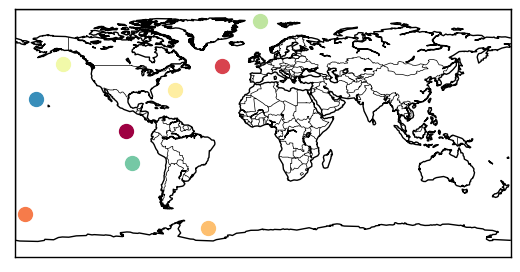

In [8]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
 
map = Basemap()
cmap=matplotlib.cm.get_cmap('Spectral', 10)
map.drawcoastlines()
map.drawcountries()
map.fillcontinents(color = 'white')
map.drawmapboundary()
x1,y1 = map(TL_m1.lon[EQ_lon], TL_m1.lat[EQ_lat])
map.plot(x1, y1, 'o', markersize=10,color=cmap(0))
x2,y2 = map(TL_m1.lon[NA_lon], TL_m1.lat[NA_lat])
map.plot(x2, y2, 'o', markersize=10,color=cmap(1))
x3,y3 = map(TL_m1.lon[SO_lon], TL_m1.lat[SO_lat])
map.plot(x3, y3, 'o', markersize=10,color=cmap(2))
x4,y4 = map(TL_m1.lon[res_lon4], TL_m1.lat[res_lat4])
map.plot(x4, y4, 'o', markersize=10,color=cmap(3))
x5,y5 = map(TL_m1.lon[BATS_lon], TL_m1.lat[BATS_lat])
map.plot(x5, y5, 'o', markersize=10,color=cmap(4))
x6,y6 = map(TL_m1.lon[SPNP_lon], TL_m1.lat[SPNP_lat])
map.plot(x6, y6, 'o', markersize=10,color=cmap(5))
x7,y7 = map(TL_m1.lon[AO_lon], TL_m1.lat[AO_lat])
map.plot(x7, y7, 'o', markersize=10,color=cmap(6))
x8,y8 = map(TL_m1.lon[SOICE_lon], TL_m1.lat[SOICE_lat])
map.plot(x8, y8, 'o', markersize=10,color=cmap(7))
x9,y9 = map(TL_m1.lon[SP_lon], TL_m1.lat[SP_lat])
map.plot(x9, y9, 'o', markersize=10,color=cmap(8))
#map.plot(TL_m1.ppChl[0,0,100, 300], 'bo', markersize=24) 
plt.show()

		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_dim: ncid 0xd0000 dimid 0
		NC4_inq_dim: ncid 0xd0000 dimid 3
		NC4_inq_dim: ncid 0xd0000 dimid 2
		NC4_inq_dim: ncid 0xd0000 dimid 1
		NC4_inq_dim: ncid 0xd0000 dimid 0
			nc4_find_dim_len: grp->name / dimid 0
		NC4_inq_dim: ncid 0xd0000 dimid 3
		NC4_inq_dim: ncid 0xd0000 dimid 2
		NC4_inq_dim: ncid 0xd0000 dimid 1
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_dim: ncid 0xd0000 dimid 0
		NC4_inq_dim: ncid 0xd0000 dimid 3
		NC4_inq_dim: ncid 0xd0000 dimid 2
		NC4_inq_dim: ncid 0xd0000 dimid 1
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_dim: ncid 0xd0000 dimid 0
		NC4_inq_dim: ncid 0xd0000 dimid 3
		NC4_inq_dim: ncid 0xd0000 dimid 2
		NC4_inq_dim: ncid 0xd0000 dimid 1
		NC4_inq_var_all: ncid 0xd0000 varid 4
			NC4_get_vars: var->hdr.name mesozoo_TL_m1 mem_nc_type 6
		NC4_inq_dim: ncid 0xd0000 dimid 0
			nc4_f

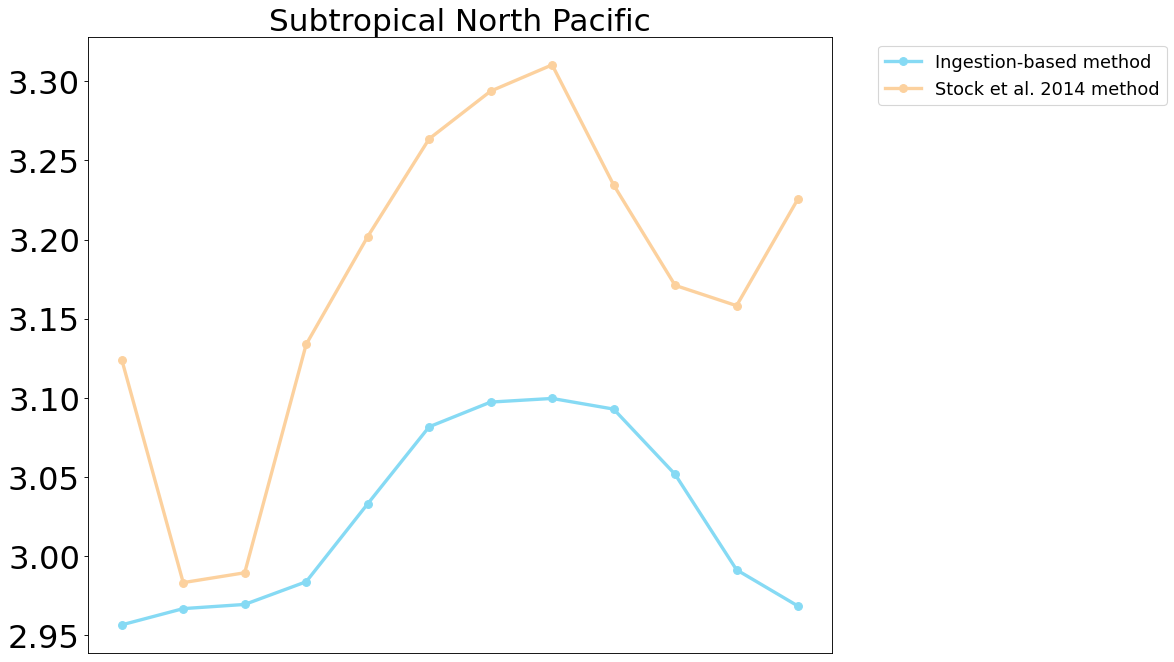

In [16]:
month = np.arange(1, 13, 1)
fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(month,SP_TL_m1, '-o', color='#86daf4',markersize=7,linewidth = 3,label='Ingestion-based method')
pylab.plot(month,SP_TL_m2, '-o', color='#FCD19E',markersize=7,linewidth = 3,label='Stock et al. 2014 method')
pylab.title('Subtropical North Pacific', fontsize=28)
pylab.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=16)
from matplotlib.pyplot import gca
a = gca()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.yticks(fontsize= 29,);plt.xticks(fontsize= 29);
pylab.show()

		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_dim: ncid 0xd0000 dimid 0
		NC4_inq_dim: ncid 0xd0000 dimid 3
		NC4_inq_dim: ncid 0xd0000 dimid 2
		NC4_inq_dim: ncid 0xd0000 dimid 1
		NC4_inq_dim: ncid 0xd0000 dimid 0
			nc4_find_dim_len: grp->name / dimid 0
		NC4_inq_dim: ncid 0xd0000 dimid 3
		NC4_inq_dim: ncid 0xd0000 dimid 2
		NC4_inq_dim: ncid 0xd0000 dimid 1
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_dim: ncid 0xd0000 dimid 0
		NC4_inq_dim: ncid 0xd0000 dimid 3
		NC4_inq_dim: ncid 0xd0000 dimid 2
		NC4_inq_dim: ncid 0xd0000 dimid 1
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_dim: ncid 0xd0000 dimid 0
		NC4_inq_dim: ncid 0xd0000 dimid 3
		NC4_inq_dim: ncid 0xd0000 dimid 2
		NC4_inq_dim: ncid 0xd0000 dimid 1
		NC4_inq_var_all: ncid 0xd0000 varid 4
			NC4_get_vars: var->hdr.name mesozoo_TL_m1 mem_nc_type 6
		NC4_inq_dim: ncid 0xd0000 dimid 0
			nc4_f

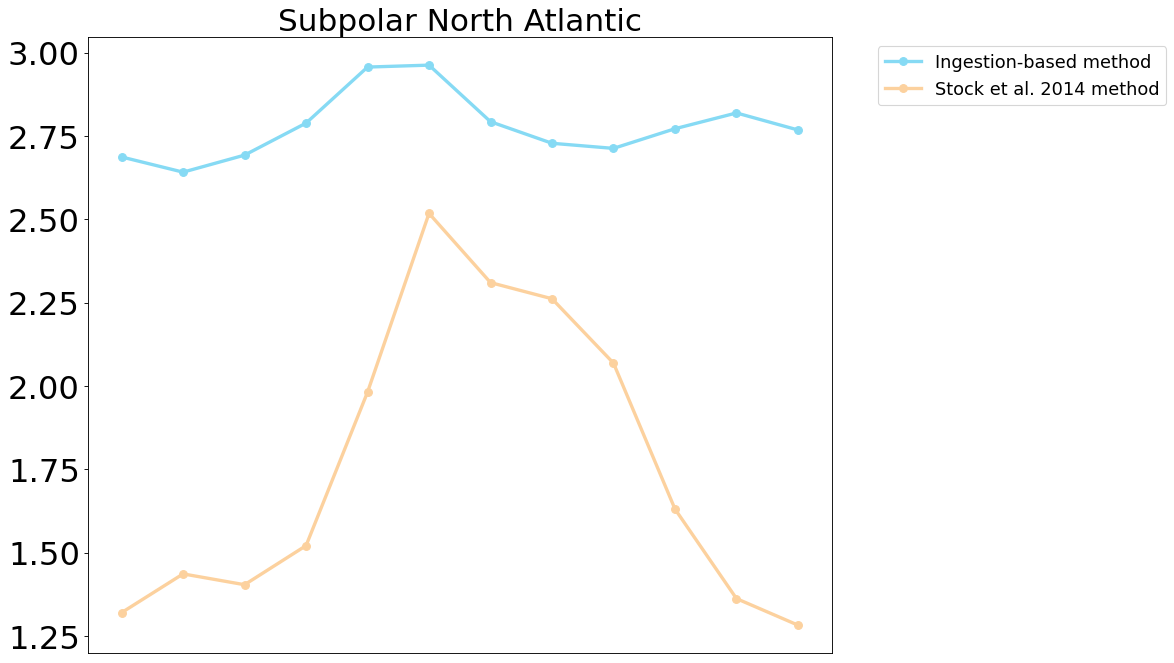

In [17]:
month = np.arange(1, 13, 1)
fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(month,NA_TL_m1, '-o', color='#86daf4',markersize=7,linewidth = 3,label='Ingestion-based method')
pylab.plot(month,NA_TL_m2, '-o', color='#FCD19E',markersize=7,linewidth = 3,label='Stock et al. 2014 method')
pylab.title('Subpolar North Atlantic', fontsize=28)
pylab.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=16)
from matplotlib.pyplot import gca
a = gca()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.yticks(fontsize= 29,);plt.xticks(fontsize= 29);
pylab.show()

		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_dim: ncid 0xd0000 dimid 0
		NC4_inq_dim: ncid 0xd0000 dimid 3
		NC4_inq_dim: ncid 0xd0000 dimid 2
		NC4_inq_dim: ncid 0xd0000 dimid 1
		NC4_inq_dim: ncid 0xd0000 dimid 0
			nc4_find_dim_len: grp->name / dimid 0
		NC4_inq_dim: ncid 0xd0000 dimid 3
		NC4_inq_dim: ncid 0xd0000 dimid 2
		NC4_inq_dim: ncid 0xd0000 dimid 1
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_dim: ncid 0xd0000 dimid 0
		NC4_inq_dim: ncid 0xd0000 dimid 3
		NC4_inq_dim: ncid 0xd0000 dimid 2
		NC4_inq_dim: ncid 0xd0000 dimid 1
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_dim: ncid 0xd0000 dimid 0
		NC4_inq_dim: ncid 0xd0000 dimid 3
		NC4_inq_dim: ncid 0xd0000 dimid 2
		NC4_inq_dim: ncid 0xd0000 dimid 1
		NC4_inq_var_all: ncid 0xd0000 varid 4
			NC4_get_vars: var->hdr.name mesozoo_TL_m1 mem_nc_type 6
		NC4_inq_dim: ncid 0xd0000 dimid 0
			nc4_f

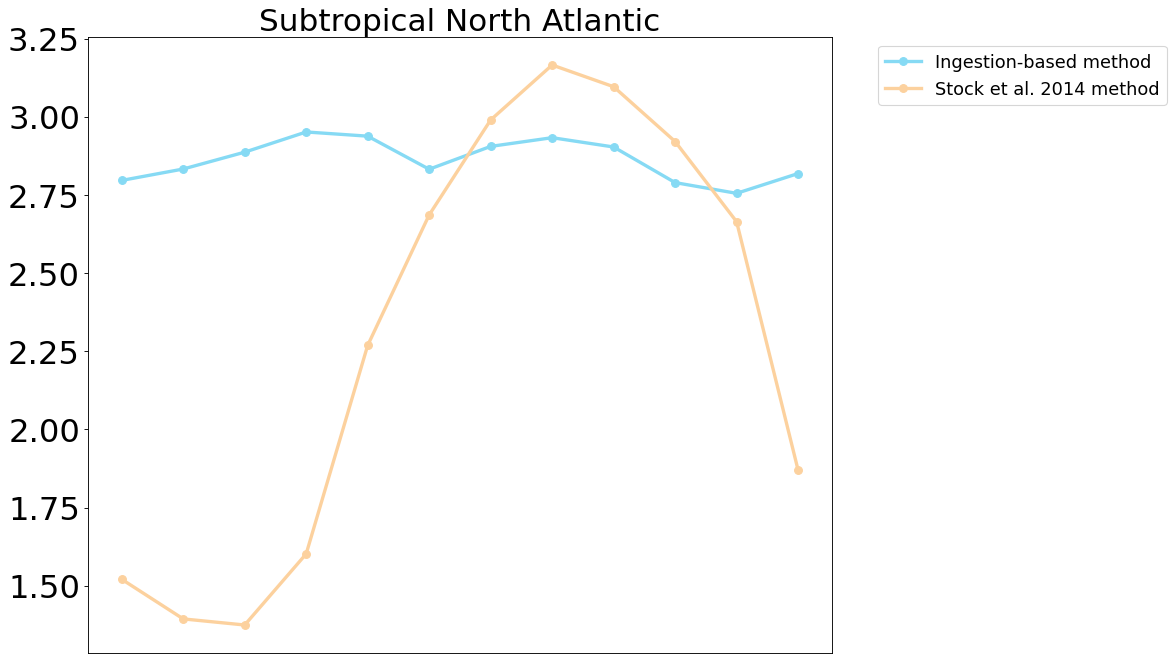

In [18]:
month = np.arange(1, 13, 1)
fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(month,BATS_TL_m1, '-o', color='#86daf4',markersize=7,linewidth = 3,label='Ingestion-based method')
pylab.plot(month,BATS_TL_m2, '-o', color='#FCD19E',markersize=7,linewidth = 3,label='Stock et al. 2014 method')
pylab.title('Subtropical North Atlantic', fontsize=28)
pylab.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=16)
from matplotlib.pyplot import gca
a = gca()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.yticks(fontsize= 29,);plt.xticks(fontsize= 29);
pylab.show()

		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_dim: ncid 0xd0000 dimid 0
		NC4_inq_dim: ncid 0xd0000 dimid 3
		NC4_inq_dim: ncid 0xd0000 dimid 2
		NC4_inq_dim: ncid 0xd0000 dimid 1
		NC4_inq_dim: ncid 0xd0000 dimid 0
			nc4_find_dim_len: grp->name / dimid 0
		NC4_inq_dim: ncid 0xd0000 dimid 3
		NC4_inq_dim: ncid 0xd0000 dimid 2
		NC4_inq_dim: ncid 0xd0000 dimid 1
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_dim: ncid 0xd0000 dimid 0
		NC4_inq_dim: ncid 0xd0000 dimid 3
		NC4_inq_dim: ncid 0xd0000 dimid 2
		NC4_inq_dim: ncid 0xd0000 dimid 1
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_dim: ncid 0xd0000 dimid 0
		NC4_inq_dim: ncid 0xd0000 dimid 3
		NC4_inq_dim: ncid 0xd0000 dimid 2
		NC4_inq_dim: ncid 0xd0000 dimid 1
		NC4_inq_var_all: ncid 0xd0000 varid 4
			NC4_get_vars: var->hdr.name mesozoo_TL_m1 mem_nc_type 6
		NC4_inq_dim: ncid 0xd0000 dimid 0
			nc4_f

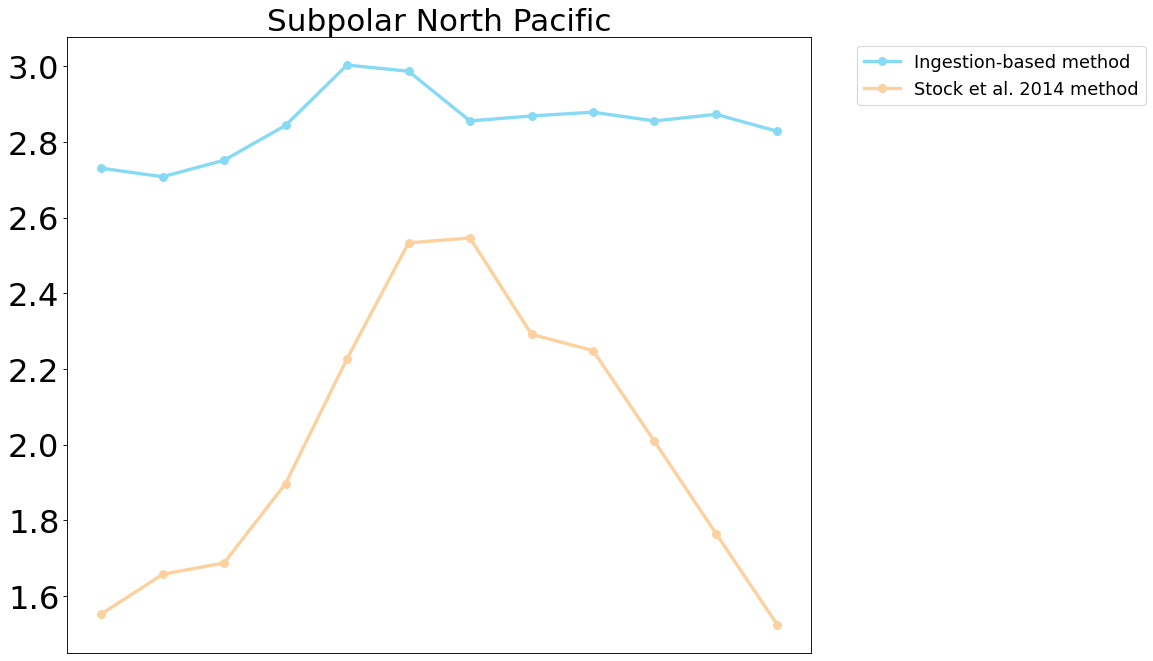

In [19]:
month = np.arange(1, 13, 1)
fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(month,PAPA_TL_m1, '-o', color='#86daf4',markersize=7,linewidth = 3,label='Ingestion-based method')
pylab.plot(month,PAPA_TL_m2, '-o', color='#FCD19E',markersize=7,linewidth = 3,label='Stock et al. 2014 method')
pylab.title('Subpolar North Pacific', fontsize=28)
pylab.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=16)
from matplotlib.pyplot import gca
a = gca()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.yticks(fontsize= 29,);plt.xticks(fontsize= 29);
pylab.show()

		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_dim: ncid 0xd0000 dimid 0
		NC4_inq_dim: ncid 0xd0000 dimid 3
		NC4_inq_dim: ncid 0xd0000 dimid 2
		NC4_inq_dim: ncid 0xd0000 dimid 1
		NC4_inq_dim: ncid 0xd0000 dimid 0
			nc4_find_dim_len: grp->name / dimid 0
		NC4_inq_dim: ncid 0xd0000 dimid 3
		NC4_inq_dim: ncid 0xd0000 dimid 2
		NC4_inq_dim: ncid 0xd0000 dimid 1
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_dim: ncid 0xd0000 dimid 0
		NC4_inq_dim: ncid 0xd0000 dimid 3
		NC4_inq_dim: ncid 0xd0000 dimid 2
		NC4_inq_dim: ncid 0xd0000 dimid 1
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_dim: ncid 0xd0000 dimid 0
		NC4_inq_dim: ncid 0xd0000 dimid 3
		NC4_inq_dim: ncid 0xd0000 dimid 2
		NC4_inq_dim: ncid 0xd0000 dimid 1
		NC4_inq_var_all: ncid 0xd0000 varid 4
			NC4_get_vars: var->hdr.name mesozoo_TL_m1 mem_nc_type 6
		NC4_inq_dim: ncid 0xd0000 dimid 0
			nc4_f

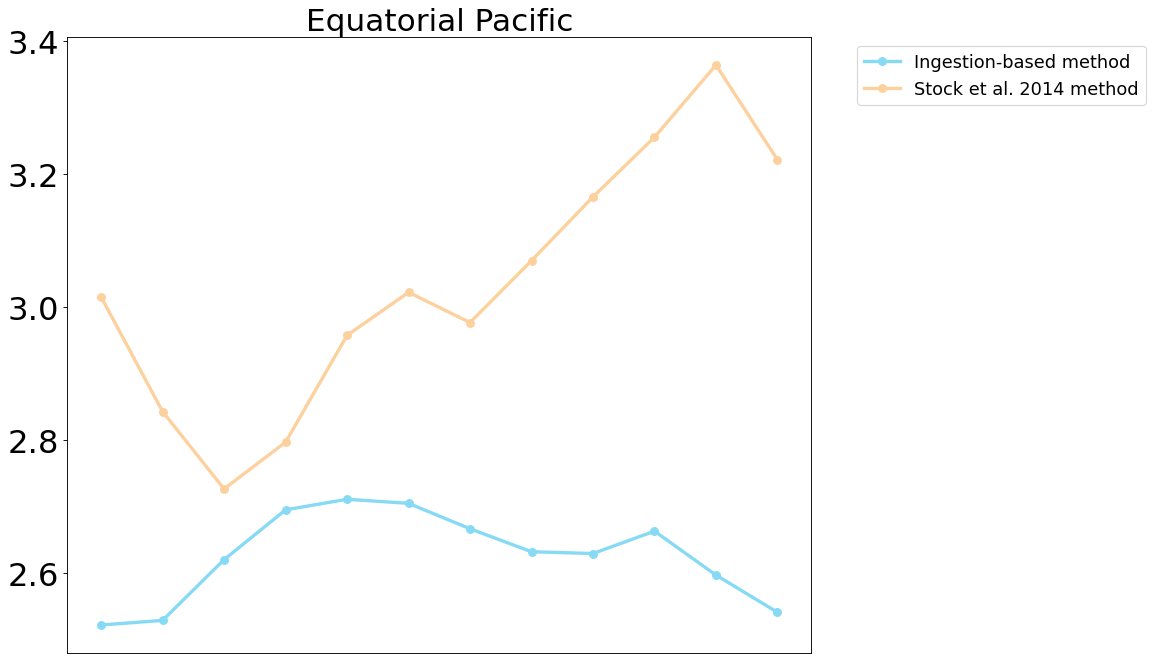

In [20]:
month = np.arange(1, 13, 1)
fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(month,EQ_OMZ_TL_m1, '-o', color='#86daf4',markersize=7,linewidth = 3,label='Ingestion-based method')
pylab.plot(month,EQ_OMZ_TL_m2, '-o', color='#FCD19E',markersize=7,linewidth = 3,label='Stock et al. 2014 method')
pylab.title('Equatorial Pacific', fontsize=28)
pylab.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=16)
from matplotlib.pyplot import gca
a = gca()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.yticks(fontsize= 29,);plt.xticks(fontsize= 29);
pylab.show()

		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_dim: ncid 0xd0000 dimid 0
		NC4_inq_dim: ncid 0xd0000 dimid 3
		NC4_inq_dim: ncid 0xd0000 dimid 2
		NC4_inq_dim: ncid 0xd0000 dimid 1
		NC4_inq_dim: ncid 0xd0000 dimid 0
			nc4_find_dim_len: grp->name / dimid 0
		NC4_inq_dim: ncid 0xd0000 dimid 3
		NC4_inq_dim: ncid 0xd0000 dimid 2
		NC4_inq_dim: ncid 0xd0000 dimid 1
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_dim: ncid 0xd0000 dimid 0
		NC4_inq_dim: ncid 0xd0000 dimid 3
		NC4_inq_dim: ncid 0xd0000 dimid 2
		NC4_inq_dim: ncid 0xd0000 dimid 1
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_dim: ncid 0xd0000 dimid 0
		NC4_inq_dim: ncid 0xd0000 dimid 3
		NC4_inq_dim: ncid 0xd0000 dimid 2
		NC4_inq_dim: ncid 0xd0000 dimid 1
		NC4_inq_var_all: ncid 0xd0000 varid 4
			NC4_get_vars: var->hdr.name mesozoo_TL_m1 mem_nc_type 6
		NC4_inq_dim: ncid 0xd0000 dimid 0
			nc4_f

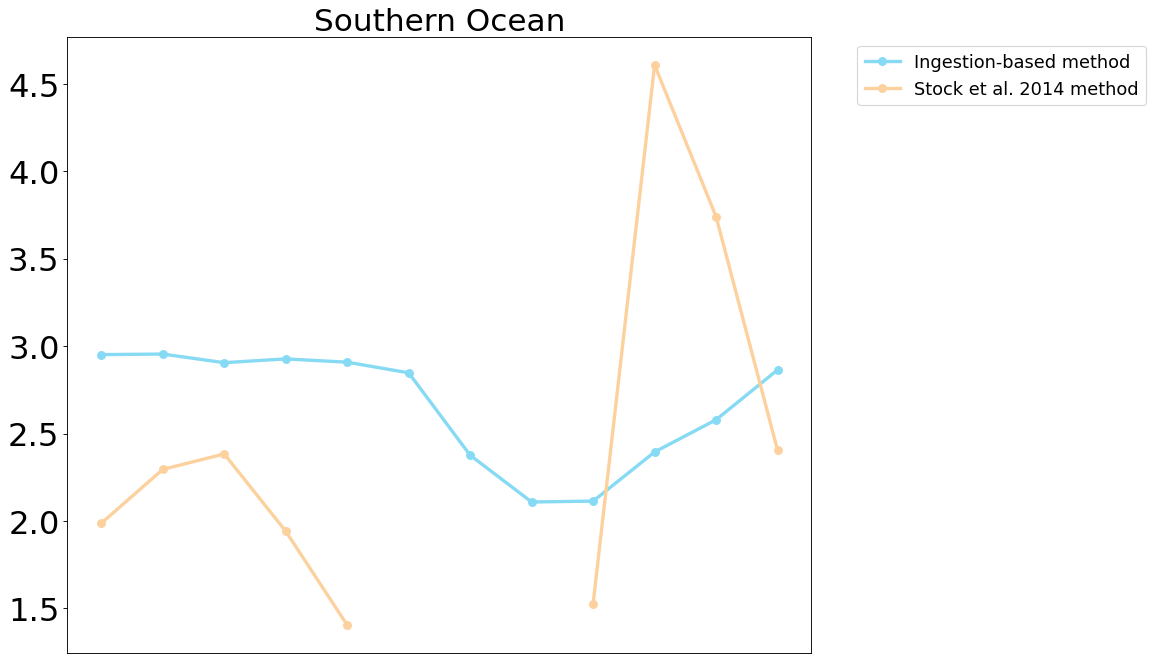

In [21]:
month = np.arange(1, 13, 1)
fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(month,SO_TL_m1, '-o', color='#86daf4',markersize=7,linewidth = 3,label='Ingestion-based method')
pylab.plot(month,SO_TL_m2, '-o', color='#FCD19E',markersize=7,linewidth = 3,label='Stock et al. 2014 method')
pylab.title('Southern Ocean', fontsize=28)
pylab.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=16)
from matplotlib.pyplot import gca
a = gca()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.yticks(fontsize= 29,);plt.xticks(fontsize= 29);
pylab.show()

		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_dim: ncid 0xd0000 dimid 0
		NC4_inq_dim: ncid 0xd0000 dimid 3
		NC4_inq_dim: ncid 0xd0000 dimid 2
		NC4_inq_dim: ncid 0xd0000 dimid 1
		NC4_inq_dim: ncid 0xd0000 dimid 0
			nc4_find_dim_len: grp->name / dimid 0
		NC4_inq_dim: ncid 0xd0000 dimid 3
		NC4_inq_dim: ncid 0xd0000 dimid 2
		NC4_inq_dim: ncid 0xd0000 dimid 1
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_dim: ncid 0xd0000 dimid 0
		NC4_inq_dim: ncid 0xd0000 dimid 3
		NC4_inq_dim: ncid 0xd0000 dimid 2
		NC4_inq_dim: ncid 0xd0000 dimid 1
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_dim: ncid 0xd0000 dimid 0
		NC4_inq_dim: ncid 0xd0000 dimid 3
		NC4_inq_dim: ncid 0xd0000 dimid 2
		NC4_inq_dim: ncid 0xd0000 dimid 1
		NC4_inq_var_all: ncid 0xd0000 varid 4
			NC4_get_vars: var->hdr.name mesozoo_TL_m1 mem_nc_type 6
		NC4_inq_dim: ncid 0xd0000 dimid 0
			nc4_f

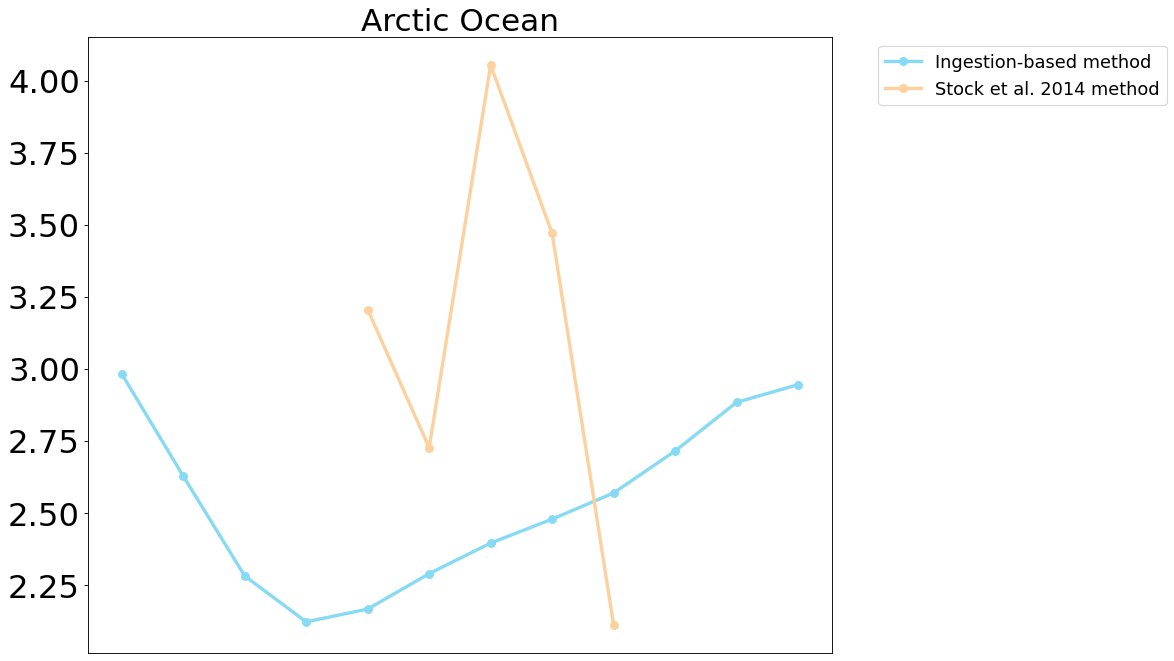

In [22]:
month = np.arange(1, 13, 1)
fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(month,AO_TL_m1, '-o', color='#86daf4',markersize=7,linewidth = 3,label='Ingestion-based method')
pylab.plot(month,AO_TL_m2, '-o', color='#FCD19E',markersize=7,linewidth = 3,label='Stock et al. 2014 method')
pylab.title('Arctic Ocean', fontsize=28)
pylab.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=16)
from matplotlib.pyplot import gca
a = gca()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.yticks(fontsize= 29,);plt.xticks(fontsize= 29);
pylab.show()

		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_dim: ncid 0xd0000 dimid 0
		NC4_inq_dim: ncid 0xd0000 dimid 3
		NC4_inq_dim: ncid 0xd0000 dimid 2
		NC4_inq_dim: ncid 0xd0000 dimid 1
		NC4_inq_dim: ncid 0xd0000 dimid 0
			nc4_find_dim_len: grp->name / dimid 0
		NC4_inq_dim: ncid 0xd0000 dimid 3
		NC4_inq_dim: ncid 0xd0000 dimid 2
		NC4_inq_dim: ncid 0xd0000 dimid 1
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_dim: ncid 0xd0000 dimid 0
		NC4_inq_dim: ncid 0xd0000 dimid 3
		NC4_inq_dim: ncid 0xd0000 dimid 2
		NC4_inq_dim: ncid 0xd0000 dimid 1
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_var_all: ncid 0xd0000 varid 4
		NC4_inq_dim: ncid 0xd0000 dimid 0
		NC4_inq_dim: ncid 0xd0000 dimid 3
		NC4_inq_dim: ncid 0xd0000 dimid 2
		NC4_inq_dim: ncid 0xd0000 dimid 1
		NC4_inq_var_all: ncid 0xd0000 varid 4
			NC4_get_vars: var->hdr.name mesozoo_TL_m1 mem_nc_type 6
		NC4_inq_dim: ncid 0xd0000 dimid 0
			nc4_f

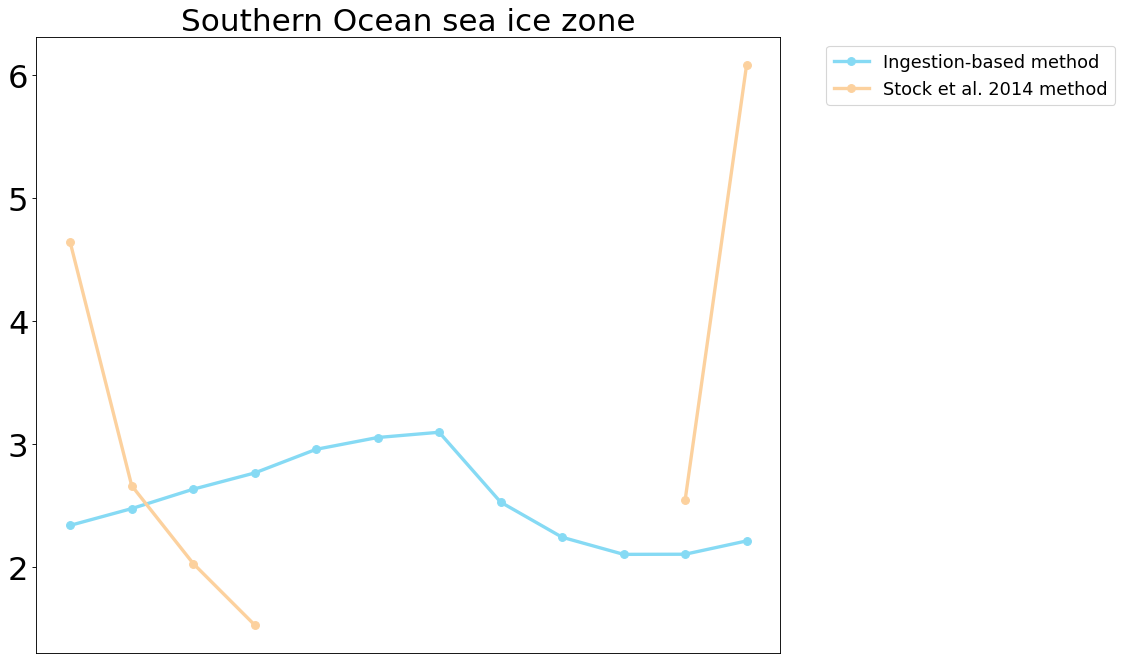

In [23]:
month = np.arange(1, 13, 1)
fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(month,SO_ICE_TL_m1, '-o', color='#86daf4',markersize=7,linewidth = 3,label='Ingestion-based method')
pylab.plot(month,SO_ICE_TL_m2, '-o', color='#FCD19E',markersize=7,linewidth = 3,label='Stock et al. 2014 method')
pylab.title('Southern Ocean sea ice zone', fontsize=28)
pylab.legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=16)
from matplotlib.pyplot import gca
a = gca()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.yticks(fontsize= 29,);plt.xticks(fontsize= 29);
pylab.show()